<a href="https://colab.research.google.com/github/krissylee/data_601_final_project/blob/main/Analysis_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maryland Statewide Vehicle Crashes Analysis in 2020-2021

# Prerequisite
  ***** Please put all the CSV files under 'dataset' folder for the codes to run properly *****

# 1. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from numpy import asarray
from sklearn.preprocessing import LabelEncoder


In [2]:
person = pd.read_csv('dataset/cleaned-person.csv')
crash = pd.read_csv('dataset/cleaned-crash.csv')
vehicle = pd.read_csv('dataset/cleaned-vehicle.csv')

In [4]:
merged_data = pd.read_csv('dataset/merged-data.csv')

## 1.1 Take a look at the datatype - merged data

In [5]:
dtype_merged = merged_data.dtypes.reset_index()
dtype_merged.columns = ['Data Name', 'Data Type']
dtype_merged

,Data Name,Data Type
0,REPORT_NO,object
1,YEAR.x,int64
2,QUARTER,object
3,LIGHT_DESC,object
4,COUNTY_DESC,object
5,COLLISION_TYPE_DESC,object
6,SURF_COND_DESC,object
7,REPORT_TYPE,object
8,WEATHER_DESC,object
9,HARM_EVENT_DESC1,object


## 1.2 Transform date of birth to age 

In [6]:
# Take a look at the original date of birth data type
merged_data.DATE_OF_BIRTH.dtype

dtype('float64')

In [7]:
# Convert this variable from float to string, then split the decimal for a tidy format
merged_data['DATE_OF_BIRTH'] = merged_data['DATE_OF_BIRTH'].astype(str).apply(lambda x: pd.to_datetime(x.split('.')[0],
                                                                  format = '%Y%m%d'))

In [19]:
# Take a look at the data type again, now we are good to go 
merged_data.DATE_OF_BIRTH.dtype

dtype('<M8[ns]')

In [20]:
# Generate the new age column
merged_data['age'] = merged_data['DATE_OF_BIRTH'].apply(lambda x: (pd.datetime.now().year - x.year))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [21]:
# # Seems good!
merged_data['age']

0        46.0
1        46.0
2        56.0
3        56.0
4        54.0
         ... 
61577    29.0
61578    29.0
61579    58.0
61580    58.0
61581     NaN
Name: age, Length: 61582, dtype: float64

## 1.3 Create lists for numerical and categorical data

In [22]:
num_var = [feature for feature in merged_data if merged_data[feature].dtypes == 'int' or merged_data[feature].dtypes == 'float']
cat_var = [feature for feature in merged_data if merged_data[feature].dtypes == 'object']

In [23]:
num_var

['YEAR.x',
 'ACC_DATE',
 'LATITUDE',
 'LONGITUDE',
 'YEAR.y',
 'AIRBAG_DEPLOYED',
 'YEAR',
 'VEH_YEAR',
 'SPEED_LIMIT',
 'age']

In [24]:
cat_var

['REPORT_NO',
 'QUARTER',
 'LIGHT_DESC',
 'COUNTY_DESC',
 'COLLISION_TYPE_DESC',
 'SURF_COND_DESC',
 'REPORT_TYPE',
 'WEATHER_DESC',
 'HARM_EVENT_DESC1',
 'HARM_EVENT_DESC2',
 'ACC_TIME',
 'LOCATION',
 'Quarter.x',
 'SEX_DESC',
 'SEX_CODE',
 'INJ_SEVER_DESC',
 'ALCOHOL_TEST_DESC',
 'ALCOHOL_TESTTYPE_DESC',
 'DRUG_TEST_DESC',
 'DRUG_TESTRESULT_DESC',
 'EJECT_DESC',
 'SAF_EQUIP_DESC',
 'Quarter.y',
 'HARM_EVENT_DESC',
 'VEH_MAKE',
 'GOING_DIRECTION_DESC',
 'HIT_AND_RUN_FLAG_DESC']

In [25]:
# Remove duplicated values
print(merged_data.duplicated().sum())
merged_data = merged_data.drop_duplicates()

0


In [26]:
# Generate descriptive statistics on the merged dataset
merged_data.describe()

,YEAR.x,ACC_DATE,LATITUDE,LONGITUDE,YEAR.y,AIRBAG_DEPLOYED,YEAR,VEH_YEAR,SPEED_LIMIT,age
count,61582.000000,6.158200e+04,61582.000000,61582.000000,61582.000000,60866.000000,61581.000000,59658.000000,61581.000000,57060.000000
mean,2020.444497,2.020506e+07,39.115047,-76.604172,2020.444497,3.872211,2020.444504,2007.909786,33.185642,38.450298
std,0.496914,4.918516e+03,0.130513,0.107457,0.496914,15.377131,0.496915,227.589125,13.599758,18.793417
min,2020.000000,2.020010e+07,38.701021,-79.730111,2020.000000,0.000000,2020.000000,0.000000,0.000000,0.000000
25%,2020.000000,2.020063e+07,39.028986,-76.662458,2020.000000,1.000000,2020.000000,2007.000000,25.000000,24.000000
50%,2020.000000,2.020112e+07,39.126541,-76.613050,2020.000000,1.000000,2020.000000,2013.000000,35.000000,35.000000
75%,2021.000000,2.021052e+07,39.179286,-76.546659,2021.000000,1.000000,2021.000000,2017.000000,45.000000,52.000000
max,2021.000000,2.021093e+07,39.990914,-75.661980,2021.000000,99.000000,2021.000000,9999.000000,75.000000,121.000000


# 2. EDA

# 2.1 Numerical Data 

In [27]:
# Once again, we load the numerical variables for reference
num_var

['YEAR.x',
 'ACC_DATE',
 'LATITUDE',
 'LONGITUDE',
 'YEAR.y',
 'AIRBAG_DEPLOYED',
 'YEAR',
 'VEH_YEAR',
 'SPEED_LIMIT',
 'age']

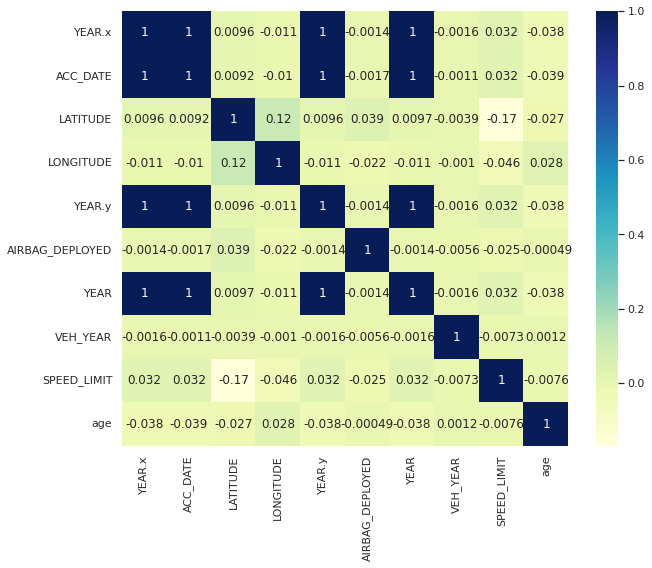

In [28]:
# Take a look at the correlation among all variables
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(merged_data.corr(), annot = True, cmap = 'YlGnBu')

There seems no significant coorelation between numerical variables.

Year.X


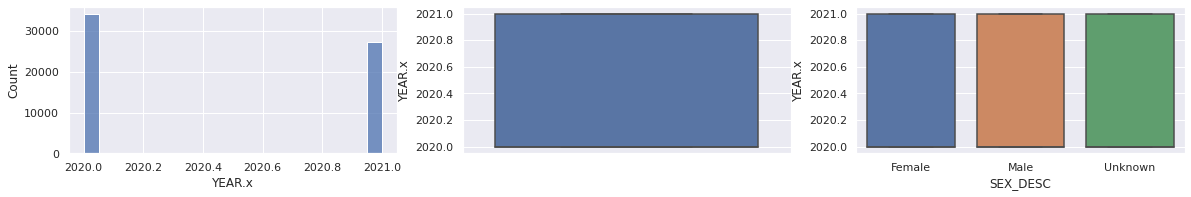

Acc_Date


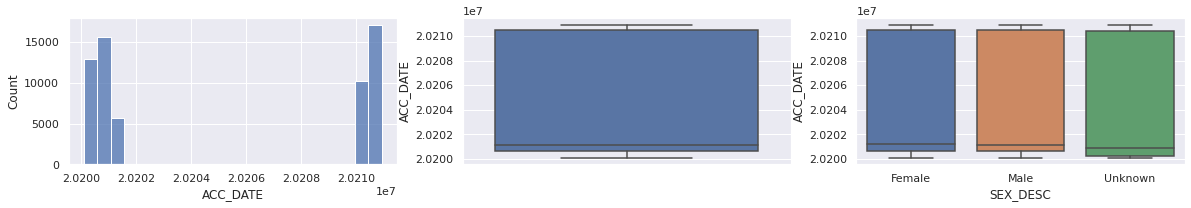

Latitude


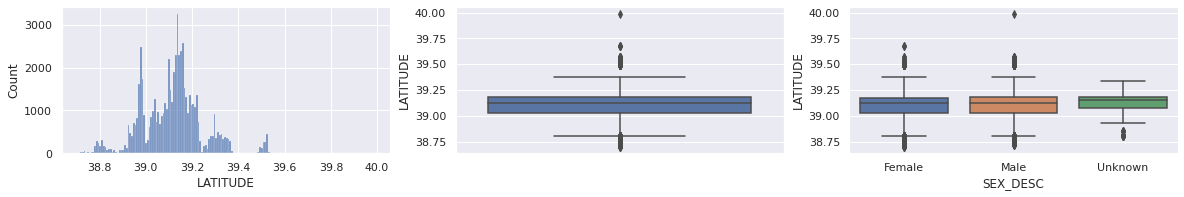

Longitude


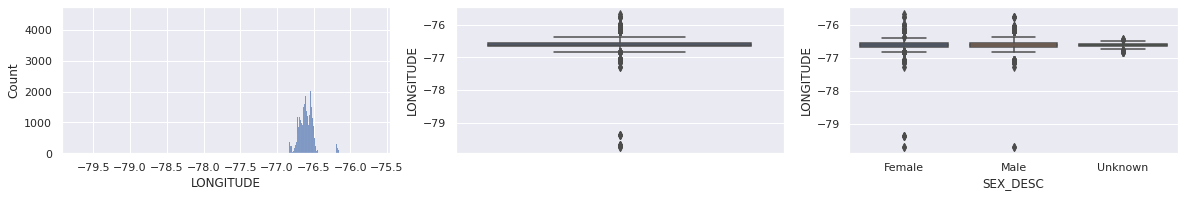

Year.Y


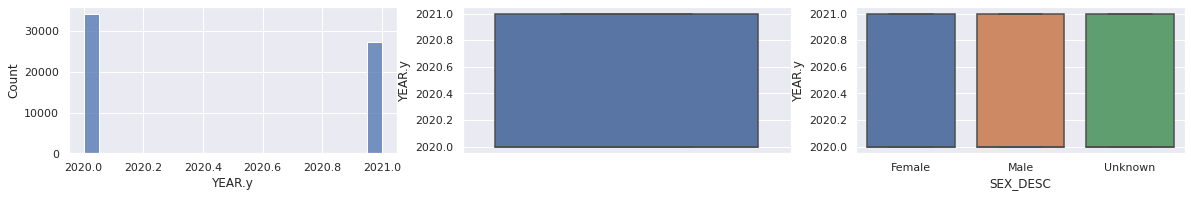

Airbag_Deployed


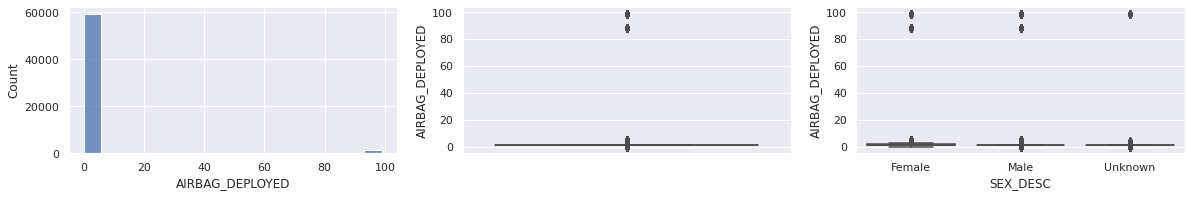

Year


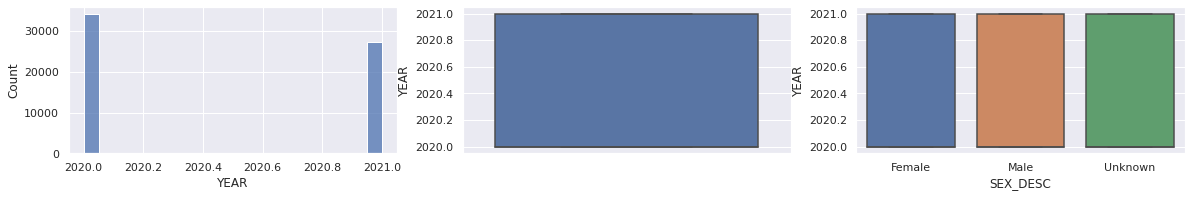

Veh_Year


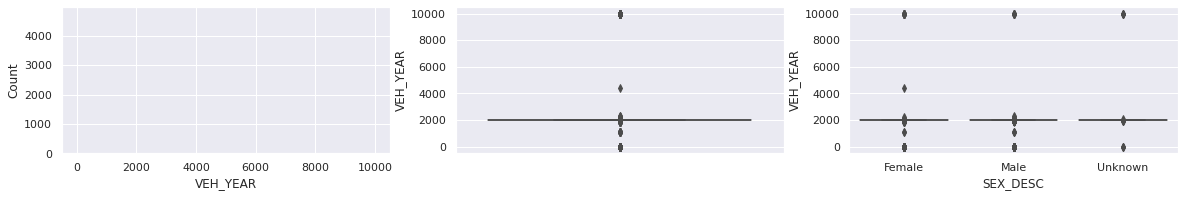

Speed_Limit


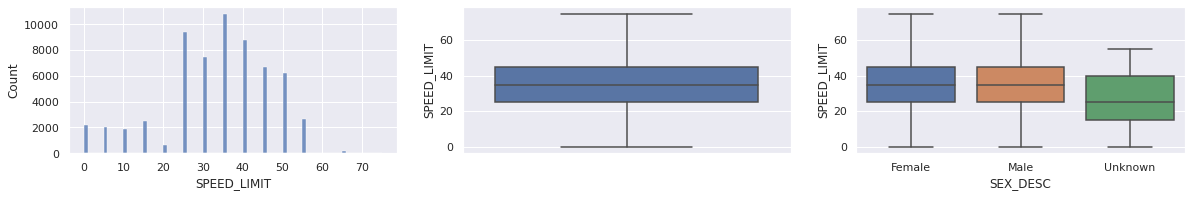

Age


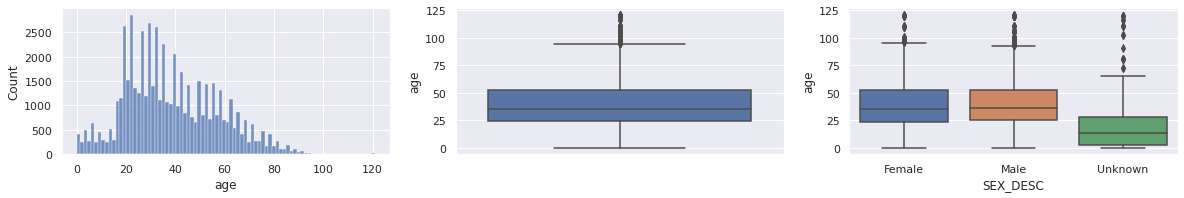

In [29]:
# Visualize all numerical variables
sns.set(style='darkgrid')

i = 1
for column in num_var:
    print(column.title())
    plt.subplots(figsize = (20, 35))
    plt.subplot(len(num_var) + 1, 3, i)
    sns.histplot(x = merged_data[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(y = merged_data[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(x = merged_data['SEX_DESC'], y = merged_data[column])
    i += 1
    plt.show()

From the plots above, we can gain these insights below:
1. Among the accidents in 2020, there's a significant drop in the spring of 2020. Even if it has some fluctuations, the number of accidents are in average around 8,0000. As for those in 2021, the accident number is steadily increasing. However, accidents are more common in 2020 than 2021. 
2. The most three common speed limit values in this crash data are 25, 35, and 55. Intrestingly, though female drivers and male drivers share a similar speed limit median value, which is around 38, more male drivers tend to drive faster than female drivers in general. 
3. Among accidents in 2020-2021, the common age range for drivers is between 20-40, which indicating Gen Z and Millennials are subject to car crashes.

## 2.1.2 Time Series Anlysis in accidents ( week, hour, month, year)

In [30]:
# Convert string to datetime object
crash['accident_date'] = pd.to_datetime(crash['ACC_DATE'], format='%Y%m%d')
crash['accident_year'] = crash['accident_date'].dt.strftime('%Y')
crash['accident_month'] = crash['accident_date'].dt.strftime('%m')
crash['accident_year_month'] = crash['accident_date'].dt.strftime('%Y-%m')

In [9]:
# Get accidents count grouped by year and month
crashes_by_year_month = crash.groupby(['accident_year_month']).size()
crashes_by_year_month

accident_year_month
2020-01    8638
2020-02    8345
2020-03    7128
2020-04    4719
2020-05    6303
2020-06    7439
2020-07    8850
2020-08    8827
2020-09    8345
2020-10    9151
2020-11    8212
2020-12    8250
2021-01    7399
2021-02    7070
2021-03    8018
2021-04    8324
2021-05    9725
2021-06    9470
2021-07    5817
2021-08    5634
2021-09    5356
dtype: int64

In [10]:
# Group accident data by three different subsets (Baltimore Couty, Baltimore City, and Prince George's County) - these are the counties which have the highest vehicle 
# crashes numbers from 2020 to 2021
baltimore_crashes = crash[crash['COUNTY_DESC']=='Baltimore']
baltimore_city_crashes = crash[crash['COUNTY_DESC']=='Baltimore City']
prince_georges_crashes = crash[crash['COUNTY_DESC']=='Prince George\'s']

In [11]:
# Get accidents count by year month for the top three vehicle crashes counties
baltimore_city_crashes_by_year_month = baltimore_city_crashes.groupby(['accident_year_month']).size()
baltimore_crashes_by_year_month = baltimore_crashes.groupby(['accident_year_month']).size()
prince_georges_crashes_by_year_month = prince_georges_crashes.groupby(['accident_year_month']).size()

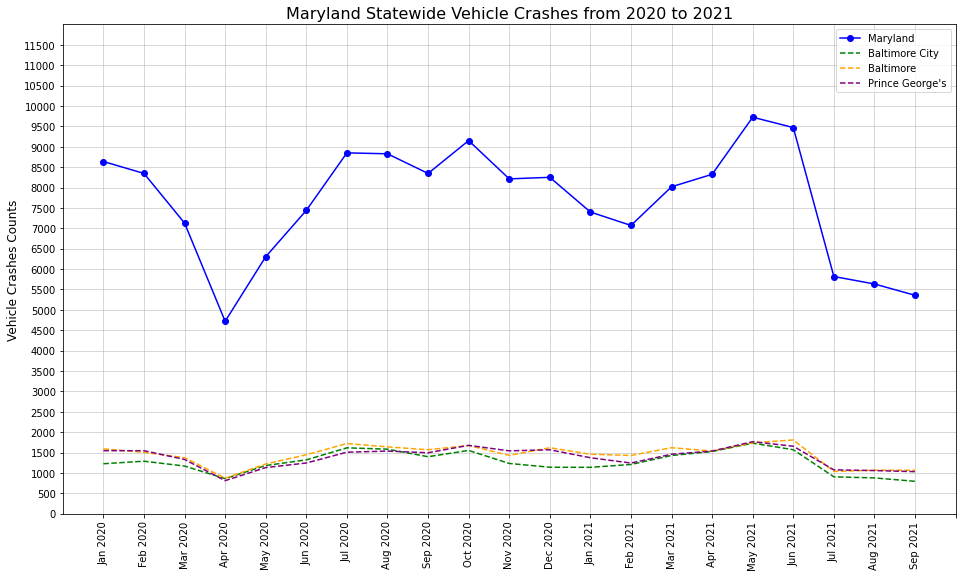

In [12]:
# Visualize the accidents count by year month in a line group
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylim(0, 12000)
plt.title("Maryland Statewide Vehicle Crashes from 2020 to 2021", fontsize=16)
plt.ylabel('Vehicle Crashes Counts', fontsize=12)
xticklabels = ['Jan 2020','Feb 2020', 'Mar 2020', 'Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020', 
                          'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021', 'Jul 2021', 'Aug 2021', 'Sep 2021']
plt.xticks(range(0, len(xticklabels)+1), labels=xticklabels, rotation='vertical')
plt.yticks(np.arange(0, 12000, 500))
plt.plot(crashes_by_year_month, color='blue', linestyle='-', marker='o', label='Maryland')
plt.plot(baltimore_city_crashes_by_year_month, color='green', linestyle='dashed', label='Baltimore City')
plt.plot(baltimore_crashes_by_year_month, color='orange', linestyle='dashed', label='Baltimore')
plt.plot(prince_georges_crashes_by_year_month, color='purple', linestyle='dashed', label='Prince George\'s')
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5')
plt.legend()
plt.show()

In [13]:
# Take out the outlier in April 2020, we wanted to see what is the true average number of crashes per month
(sum(crashes_by_year_month)-crashes_by_year_month['2020-04']) / (len(crashes_by_year_month)-1)

7815.05

From what we see from the line graph, there was a big dip of vehicle crashes in April 2020. This is largely due to the number of vehicles on the road was reduced in response to the national emergency of COVID-19 pandemic.  The former President declared Proclaimtion 9994 on March 13, 2020 declaring a National Emergency concerning the novel Coronavirus disease outbreak. This is a speculation of most federal employees and some workforces in the private sectors were offered to work remotely to slow down the spread of Coronavirus, that could be a contributing factor of the drop. In order for us to establish whether a strong correlation exists between traffic and crashes, traffic data is necessary to evaluate whether traffic patterns changes had contributed to the reduction of accidents around the time.  

In [14]:
# Process the accident date using datetime object in pandas
merged_data['accident_date'] = pd.to_datetime(merged_data['ACC_DATE'].astype(str), format = '%Y-%m-%d')
merged_data['accident_date']

0       2020-08-26
1       2020-08-26
2       2020-08-26
3       2020-08-26
4       2020-08-26
           ...    
61577   2020-03-31
61578   2020-03-31
61579   2020-03-31
61580   2020-03-31
61581   2020-03-31
Name: accident_date, Length: 61582, dtype: datetime64[ns]

In [15]:
# Create the full datetime object that includes both date and time of each accident
merged_data['accident_datetime'] = pd.to_datetime(merged_data.accident_date.astype(str) + ' ' +
                                                  merged_data.ACC_TIME.astype(str), format = '%Y-%m-%d %H:%M:%S')
merged_data['accident_datetime']

0       2020-08-26 07:25:00
1       2020-08-26 07:25:00
2       2020-08-26 07:25:00
3       2020-08-26 07:25:00
4       2020-08-26 07:25:00
                ...        
61577   2020-03-31 18:18:00
61578   2020-03-31 18:18:00
61579   2020-03-31 18:18:00
61580   2020-03-31 18:18:00
61581   2020-03-31 18:18:00
Name: accident_datetime, Length: 61582, dtype: datetime64[ns]

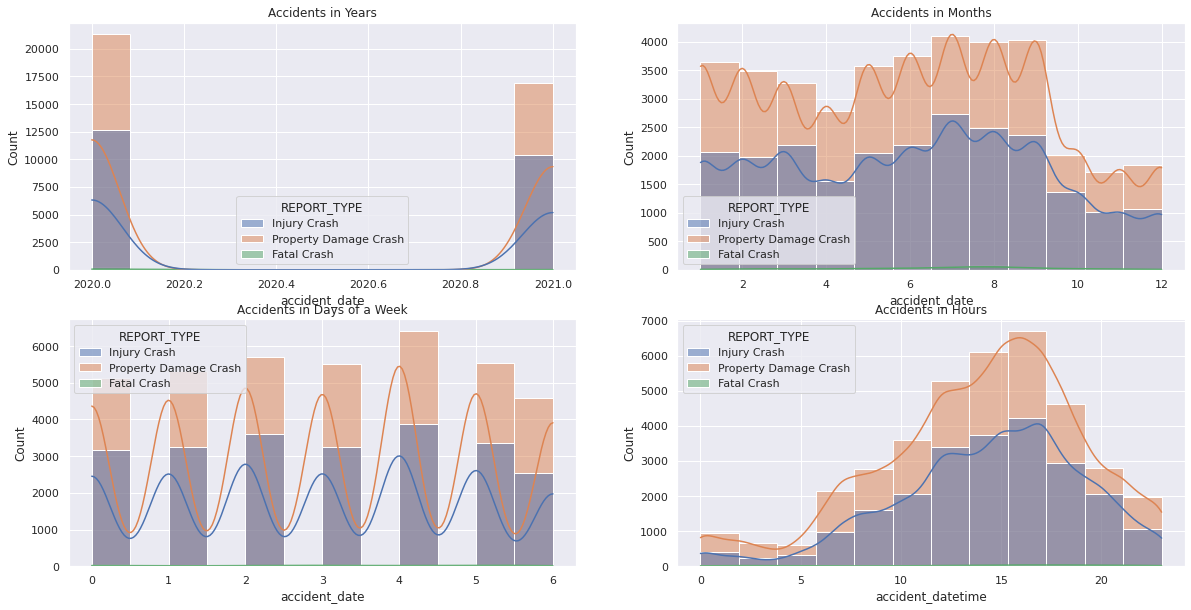

In [16]:
sns.set(style='darkgrid')

fig, axs = plt.subplots(2,2, figsize = (20,10)) 

sns.histplot(data = merged_data, x = merged_data.accident_date.dt.year, bins = 12, 
             hue = merged_data.REPORT_TYPE, kde = True, color = 'skyblue', ax = axs[0,0]).set(title = 'Accidents in Years')


sns.histplot(data = merged_data, x = merged_data.accident_date.dt.month, bins = 12,
             hue = merged_data.REPORT_TYPE, kde = True, color = 'olive', ax = axs[0,1]).set(title = 'Accidents in Months')

sns.histplot(data = merged_data, x = merged_data.accident_date.dt.weekday, bins = 12,
            hue = merged_data.REPORT_TYPE, kde = True, color = 'gold', ax = axs[1,0]).set(title = 'Accidents in Days of a Week')

sns.histplot(data = merged_data, x = merged_data.accident_datetime.dt.hour, bins = 12,
             hue = merged_data.REPORT_TYPE, kde = True, color = 'teal',ax = axs[1,1]).set(title = 'Accidents in Hours')



plt.show()

From the plots above, we can find these insights below:

1. Property Damage Crash is the most common report type among all accidents in 2020-2021.
2. Most accidents happened in summer (July, August, September), while much less accidents happened in winter (October, November, December).
3. Insteresting still, Thursday turns out having the greatest number of accidents.
4. Most accidents happened between 4pm-5pm, which matches the common off-work time.

# 2.2 Categorical Data 

In [31]:
cat_var

['REPORT_NO',
 'QUARTER',
 'LIGHT_DESC',
 'COUNTY_DESC',
 'COLLISION_TYPE_DESC',
 'SURF_COND_DESC',
 'REPORT_TYPE',
 'WEATHER_DESC',
 'HARM_EVENT_DESC1',
 'HARM_EVENT_DESC2',
 'ACC_TIME',
 'LOCATION',
 'Quarter.x',
 'SEX_DESC',
 'SEX_CODE',
 'INJ_SEVER_DESC',
 'ALCOHOL_TEST_DESC',
 'ALCOHOL_TESTTYPE_DESC',
 'DRUG_TEST_DESC',
 'DRUG_TESTRESULT_DESC',
 'EJECT_DESC',
 'SAF_EQUIP_DESC',
 'Quarter.y',
 'HARM_EVENT_DESC',
 'VEH_MAKE',
 'GOING_DIRECTION_DESC',
 'HIT_AND_RUN_FLAG_DESC']

In [32]:
# Drop unnecessary variables for visualization
cat_var = list(set(cat_var) - set(['REPORT_NO', 'ACC_TIME','SEX_CODE','VEH_MAKE']))
cat_var

['DRUG_TESTRESULT_DESC',
 'SURF_COND_DESC',
 'COUNTY_DESC',
 'ALCOHOL_TEST_DESC',
 'REPORT_TYPE',
 'COLLISION_TYPE_DESC',
 'GOING_DIRECTION_DESC',
 'LOCATION',
 'EJECT_DESC',
 'LIGHT_DESC',
 'WEATHER_DESC',
 'SAF_EQUIP_DESC',
 'DRUG_TEST_DESC',
 'HARM_EVENT_DESC1',
 'Quarter.y',
 'HARM_EVENT_DESC',
 'Quarter.x',
 'SEX_DESC',
 'HIT_AND_RUN_FLAG_DESC',
 'HARM_EVENT_DESC2',
 'INJ_SEVER_DESC',
 'ALCOHOL_TESTTYPE_DESC',
 'QUARTER']

Drug_Testresult_Desc


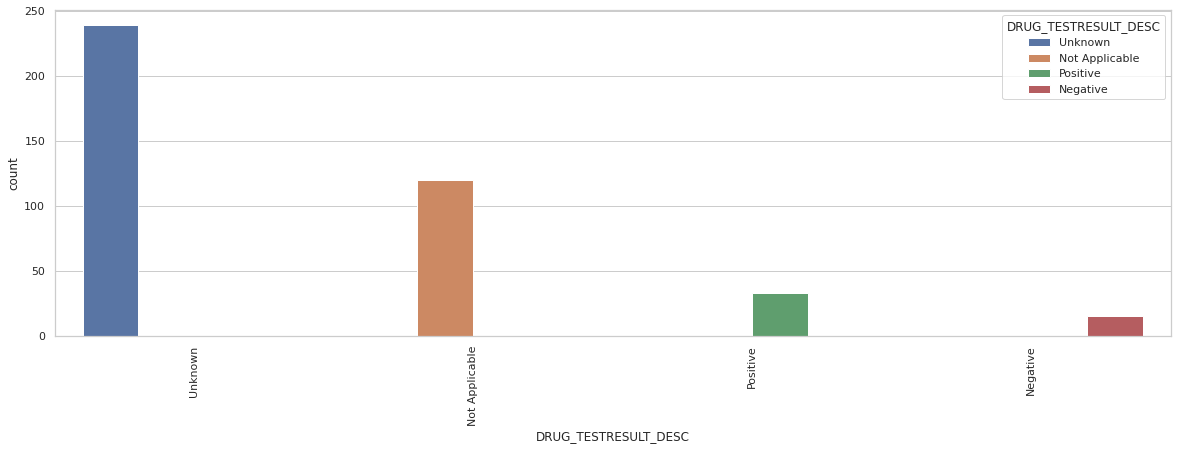

Surf_Cond_Desc


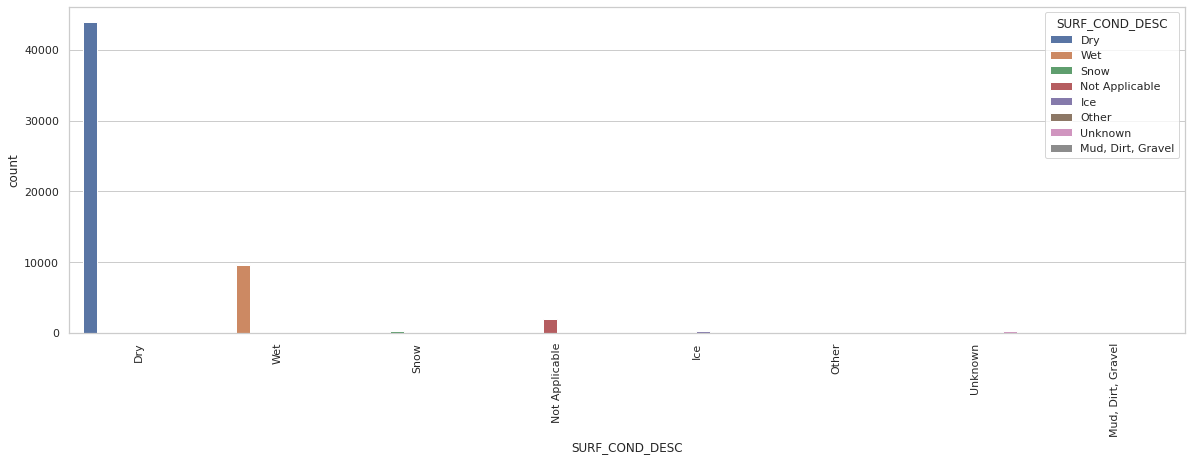

County_Desc


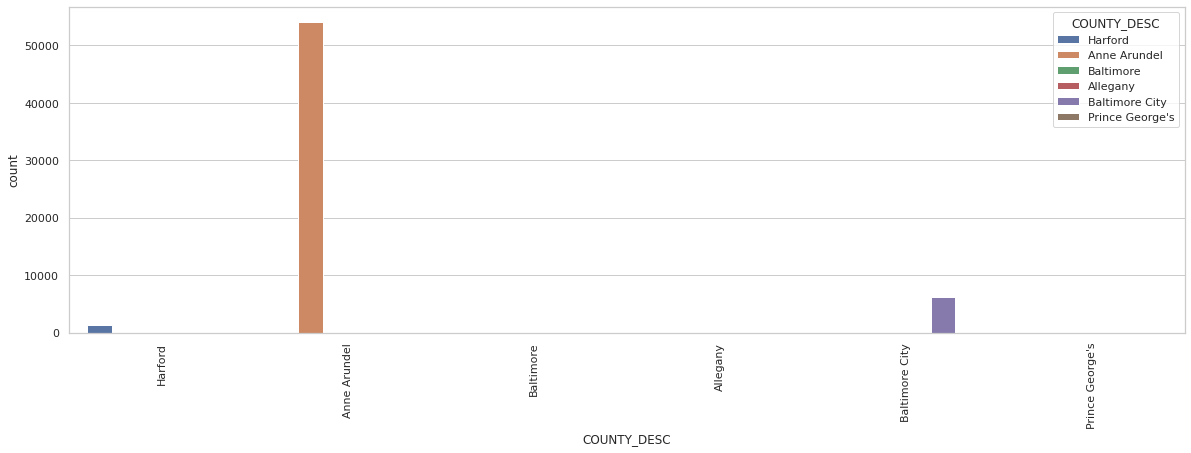

Alcohol_Test_Desc


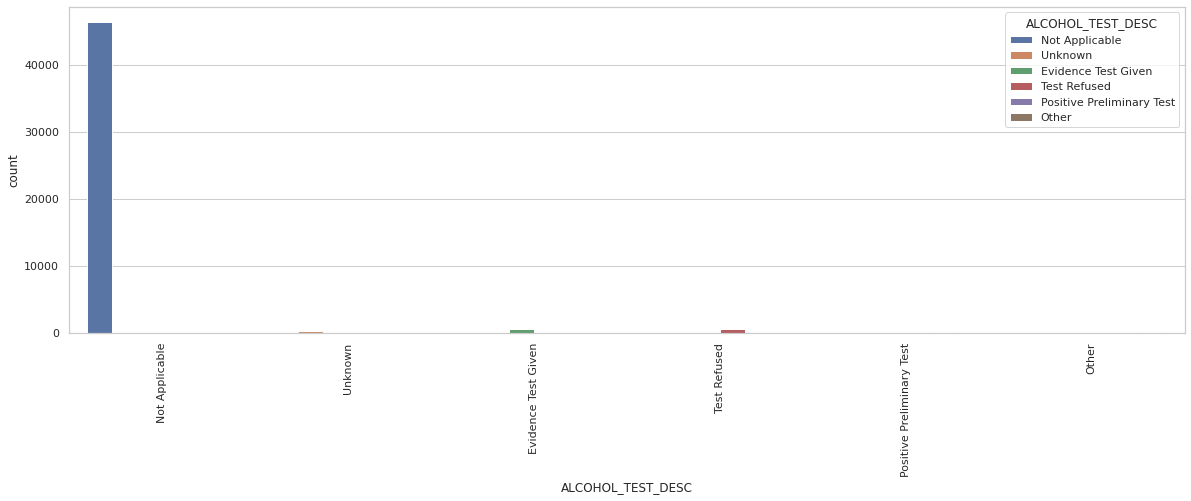

Report_Type


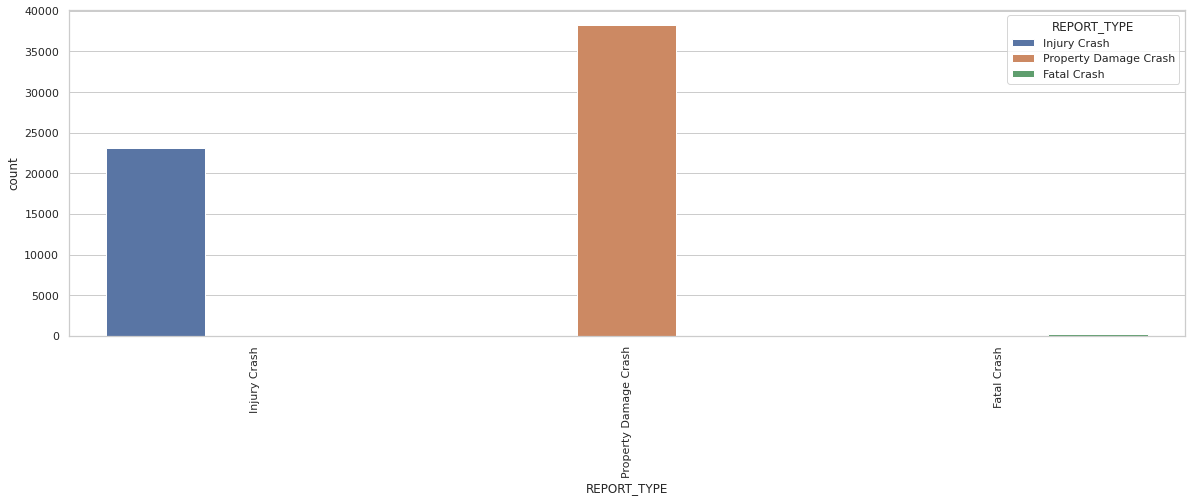

Collision_Type_Desc


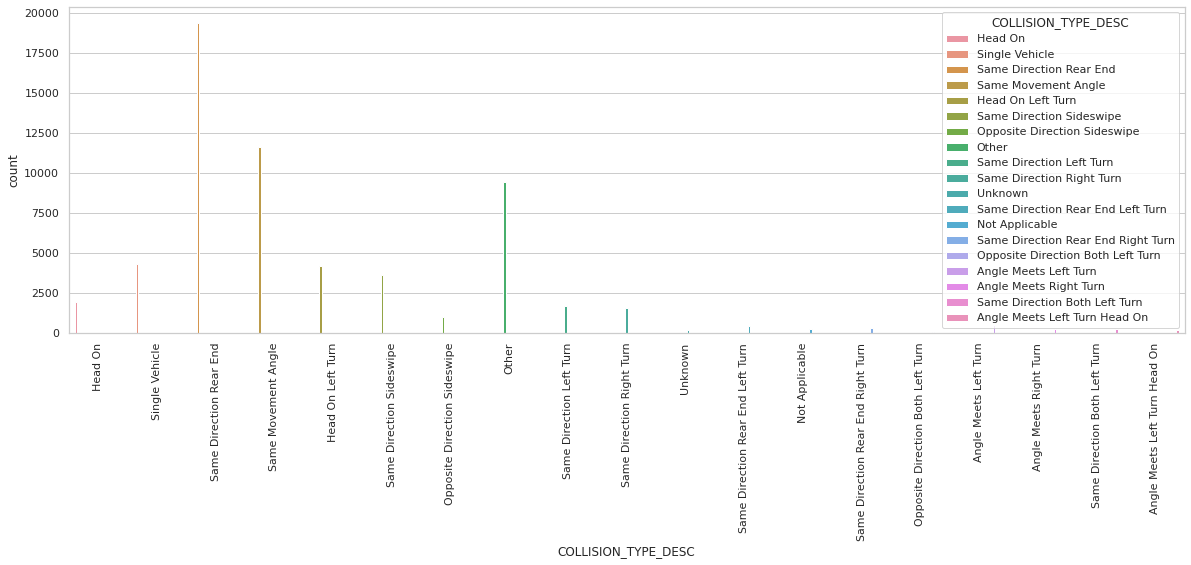

Going_Direction_Desc


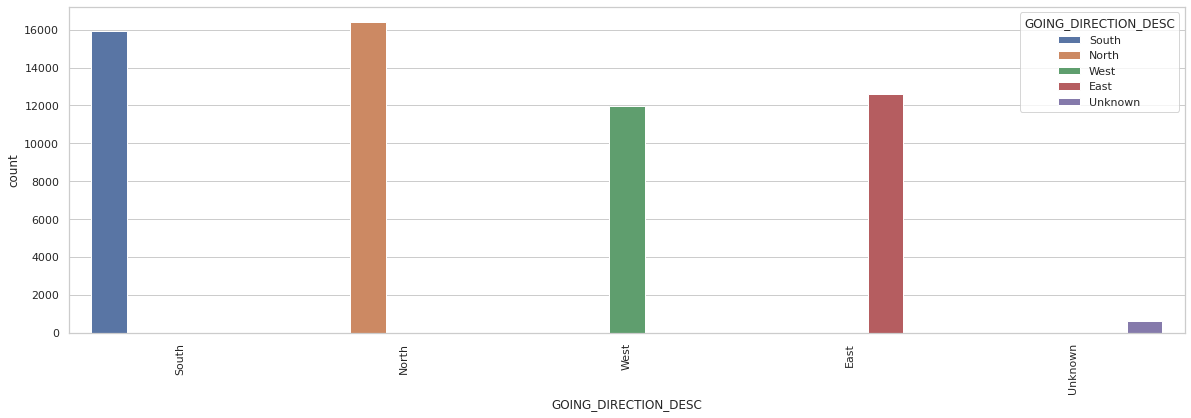

Location


In [ ]:
# Visualize all categorical variables 
for column in cat_var:
    plt.figure(figsize = (20, 6))
    print(column.title())
    sns.set_theme(style = 'whitegrid', color_codes = True)
    ax = sns.countplot(x = merged_data[column], hue = merged_data[column])
    plt.xticks(rotation = 90)
    plt.show()

From the plots above, we can find these insights below:
1. Most accidents involved fixed objects.
2. In accidents with valid drug test results, most drivers hold positive, which marks drug-use a big concern in accidents.
3. Most accidents happened in either the same direction rear end or in the same movement angle.
4. All in all, male drivers are recorded in crashes between 2020-2021 than female drivers.
5. Baltimore, Baltimore City, and Prince George's rank the top 3 counties concerning accidents in Maryland.
6. Most accidents happened in the direction either going North or South.
7. Even if most accidents happened during raining days, the number of accidents in a dry surface condition outweigh those in a wet surface condition. This indicates that not only driving in unusal weather should be cautious, driving in a normal day also deserves equal attention. 
8. Luckily, most accidents don't incur severe injury, which makes sense when drivers didn't eject or trap in their cars in the spot. 
9. Most drivers are compliant to basic safety equipment rule by setting up their shoulder/lap belts. Understanbly, most of them didn't hit and run in all. 
10. Parked vehicles have the greates number of accidents. 
11. Most accidents happened to vehicles with the day light one, which makes sense as 4pm-5pm is the common crash time.

---

In [ ]:
merged_data.head()

## 2.3 Age Analysis

In [ ]:
# Age analysis
sns.set(style='whitegrid')

fig, axs = plt.subplots(2,2, figsize = (20,10)) 

sns.histplot(data = merged_data, x = 'age', bins = 12, 
              kde = True, color = 'lightpink', ax = axs[0,0]).set(title = 'The age distribution in accidents')


sns.histplot(data = merged_data, x = 'age', bins = 12,
             hue = 'SEX_DESC', kde = True, color = 'lightblue', ax = axs[0,1]).set(title = 'Gender/Age distribution in accidents')


sns.violinplot(data = merged_data, x = 'DRUG_TESTRESULT_DESC',y = 'age',
             hue = 'SEX_CODE', kde = True, color = 'olive', ax = axs[1,0]).set(title = 'Gender/Age distribution in drug test result')

sns.violinplot(data = merged_data, x = 'ALCOHOL_TEST_DESC', y= 'age',
              hue = merged_data.SEX_CODE, kde = True, color = 'gold', ax = axs[1,1]).set(title = 'Gender/Age distribution in alcohol test result')
plt.xticks(rotation = 90)






- Unlike the traditional views that teen drivers (under age 20) and senior drivers (age 60-80) tend to have the highest rates of crash involvement, this case shows that adult drivers (age 20-30) have involved the highest numbers of car accidents. This is validated by a new study from AAA Foundation for Traffic Safety: Young adult drivers report engaging in dangerous driving behavior more than any other age group.

- While looking into the gender distribution among these age groups, there’s no significant difference in the number of female and male drivers in teens and seniors. However, among drivers aged 20-60, male drivers have a more significant number of accidents than female drivers. 

- When associating DUI with different age groups, a significant shared feature is that drug and alcohol problems in accidents are primarily focused on the adults' group, which may account for one of the reasons they have the highest involvement in crashes. Specifically, drug use in male drivers is more severe than female drivers, impacting people from a wider age group. 

# 3. Transformation

## 3.1 Handling Missing Values

In [ ]:
merged_data['ACC_TIME']

In [ ]:
merged_data['ACC_DATE']

In [ ]:
# Extract year, month, weekday, hour from 'accident_date' and 'accident_datetime'
merged_data['Year'] = merged_data['accident_date'].dt.year
merged_data['Month'] = merged_data['accident_date'].dt.month
merged_data['Weekday'] = merged_data['accident_date'].dt.weekday
merged_data['Hour'] = merged_data['accident_datetime'].dt.hour

In [ ]:
# Deal with missing data
plt.style.available
plt.style.use('seaborn-whitegrid')

missing_data = merged_data.isnull().sum(axis = 0).reset_index()
missing_data.columns = ['column_name', 'missing_value_count']
missing_data = missing_data.loc[missing_data['missing_value_count'] > 0]
missing_data = missing_data.sort_values(by = 'missing_value_count')

index = np.arange(missing_data.shape[0])
fig,ax = plt.subplots(figsize=(10,5))
rects = ax.barh(index, missing_data.missing_value_count.values)
ax.set_yticks(index)
ax.set_yticklabels(missing_data.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [ ]:
merged_data.shape

In [ ]:
# Handling missing values in numeric data 
df = merged_data
df['age'] = df['age'].fillna(df['age'].mean())
df['VEH_YEAR'] = df['VEH_YEAR'].fillna(df['VEH_YEAR'].mean())
df['AIRBAG_DEPLOYED'] = df['AIRBAG_DEPLOYED'].fillna(df['AIRBAG_DEPLOYED'].mean())

In [ ]:
# Handling missing values in categorical data
df['DRUG_TESTRESULT_DESC'] = df['DRUG_TESTRESULT_DESC'].fillna('Unknown')
df['ALCOHOL_TESTTYPE_DESC'] = df['ALCOHOL_TESTTYPE_DESC'].fillna('Unkown')
df['WEATHER_DESC'] = df['WEATHER_DESC'].fillna('Unknown')
df['DRUG_TEST_DESC'] = df['DRUG_TEST_DESC'].fillna('Unknown')
df['ALCOHOL_TEST_DESC'] = df['ALCOHOL_TEST_DESC'].fillna('Unknown')
df['HARM_EVENT_DESC1'] = df['HARM_EVENT_DESC1'].fillna('Unknown')
df['SEX_CODE'] = df['SEX_CODE'].fillna('Unknown')
df['SEX_DESC'] = df['SEX_DESC'].fillna('Unknown')
df['GOING_DIRECTION_DESC'] = df['GOING_DIRECTION_DESC'].fillna('Unknown')
df['SURF_COND_DESC'] = df['SURF_COND_DESC'].fillna('Unknown')
df['LIGHT_DESC'] = df['LIGHT_DESC'].fillna('Unknown')
df['EJECT_DESC'] = df['EJECT_DESC'].fillna('Unknown')
df['HIT_AND_RUN_FLAG_DESC'] = df['HIT_AND_RUN_FLAG_DESC'].fillna('Unknown')
df['VEH_MAKE'] = df['VEH_MAKE'].fillna('Unknown')
df['COUNTY_DESC'] = df['COUNTY_DESC'].fillna('Unknown')

In [ ]:
# Since we've got age, let's drop the date of birth
df = df.drop('DATE_OF_BIRTH',axis = 1)

In [ ]:
df.isnull().mean()

## 3.2 Feature Encoding

In [ ]:
# Select the three Counties' subset
select_df = df.loc[(df['COUNTY_DESC'] == 'Baltimore') | (df['COUNTY_DESC'] == 'Baltimore City') | (df['COUNTY_DESC'] == "Prince's George")]

In [ ]:
dtype_select_df = select_df.dtypes.reset_index()
dtype_select_df.columns = ['Data Name', 'Data Type']
dtype_select_df

In [ ]:
select_df.head()

In [ ]:
# Drop unecessary columns for modeling
select_df = select_df.drop(['REPORT_NO', 'ACC_DATE','ACC_TIME','YEAR','accident_date','accident_datetime',
                           'SEX_DESC', 'ALCOHOL_TESTTYPE_DESC','DRUG_TESTRESULT_DESC'],axis = 1)

In [ ]:
select_df.info()

In [ ]:
select_df.shape

In [ ]:
select_df

In [ ]:
# Define one hot encoding
labelencoder = LabelEncoder()
# transform data
select_df_dummy3.iloc[:,0] = labelencoder.fit_transform(select_df_dummy3.iloc[:,0])

In [ ]:
select_df.info()

In [ ]:
# Generate dummies for categorical data
select_df_dummy3 = pd.get_dummies(select_df, drop_first=True, 
                                 columns = ['LIGHT_DESC', 'COLLISION_TYPE_DESC','SURF_COND_DESC','WEATHER_DESC','HARM_EVENT_DESC1',
                                           'HARM_EVENT_DESC2','SEX_CODE', 'INJ_SEVER_DESC', 'QUARTER','ALCOHOL_TEST_DESC',
                                           'DRUG_TEST_DESC', 'EJECT_DESC', 'SAF_EQUIP_DESC','HARM_EVENT_DESC', 'VEH_MAKE',
                                            'GOING_DIRECTION_DESC','HIT_AND_RUN_FLAG_DESC'])


In [ ]:
select_df_dummy3 = pd.get_dummies(select_df_dummy3, drop_first = True,
                                columns = ['COUNTY_DESC'])

In [ ]:
select_df_dummy3

In [ ]:
# Property Damage Crash - 2, Injury Crash - 1, Fatal Crash - 0
select_df_dummy3.REPORT_TYPE.unique()

## 4. Modeling

In [ ]:
# Set X and y
X = select_df_dummy3.iloc[:, 1:2021]
y = select_df_dummy3.iloc[:,0]

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify = y)

In [ ]:
# List of classification algorithms
algorithm_list=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_list=[]

## 

In [ ]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append the score to the accuracy list
accuracy_list.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))


In [ ]:
# KNN (The K-Nearest Neighbors) algorithm
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Predict the results for training data
y_pred = knn.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append the score to the accruacy list
accuracy_list.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

In [ ]:
# Random Forest - n_estimators = 100
clf = RandomForestClassifier(n_estimators = 100)
# Train the model and predict the results
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append the score to the accuracy list
accuracy_list.append(acc)

# Print the model accuracy
print("[Random Forest Algorithm] accuracy_score: {:.3f}.".format(acc))

In [ ]:
# Random Forest - visualize important features
feature_imp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
# Create a bar plot for the top k features
k = 10
sns.set_theme(style='whitegrid')
sns.barplot(x = feature_imp[:10], y =feature_imp.index[:k])
# Add details to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend()
plt.show()

In [ ]:
# List the top k important features
k = 20
feature_imp.sort_values(ascending = False)[:k]

In [ ]:
# Select the top imporant features while settingg up a threshold
# Create an object applying the random forest classifier to identify features that reach and beyond the threshold 0.02
sfm = SelectFromModel(clf, threshold = 0.02)

# Fit the selector with training set data
sfm.fit(X_train, y_train)
feat_labels = X.columns

# Print out these selected important features
for feature_list_index in sfm.get_support(indices = True):
    print(feat_labels[feature_list_index])


In [ ]:
# Create a new dataset containing these important features 
# Transform them to both training and test sets
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for these important features
clf_important = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)

# Train the classifier to new datasets again
clf_important.fit(X_important_train, y_train)

In [ ]:
# Apply the previous classifier to the test data
y_pred = clf.predict(X_test)
# Take a look at the accuracy of the previous model
print('[Random Forest Algorithm with general features] accuracy score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))
# Apply this new classifier to the test data
y_important_pred = clf_important.predict(X_important_test)
# Take a look at the accuracy of the new model
print('[Random Forest Algorithm with limited features] accuracy score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

acc = accuracy_score(y_test,y_important_pred)
accuracy_list.append(acc)


In [ ]:
acc = accuracy_score(y_test,y_important_pred)
accuracy_list.append(acc)

In [ ]:
# Visualize the accuracy of the algorithms

# Add the y ticks
y_ticks = np.arange(len(algorithm_list))
# Convert the lists we created before to a dataframe
df_acc = pd.DataFrame(list(zip(algorithm_list, accuracy_list)), columns = ['Algorithm Name','Accuracy Score']).sort_values(by = ['Accuracy Score'], ascending = True)
# Create the plot
ax = df_acc.plot.barh('Algorithm Name', 'Accuracy Score', align = 'center', legend = False, colormap='RdBu')
for i in ax.patches:
    ax.text(i.get_width()+0.01, i.get_y()+0.01, str(round(i.get_width(), 2)), fontsize = 10)

# Add labels 
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm Name'], rotation = 0)
plt.title('The Accuracy of Algorithms')
plt.show()
    

## 5. Feature Engineering

# 6. Results

In [ ]:
person.shape

In [ ]:
person.head()

In [ ]:
crash.shape

In [ ]:
crash.head()

In [ ]:
vehicle.shape

In [ ]:
vehicle.head()

In [ ]:
merged_data.shape

In [ ]:
merged_data.head()

# The crash accidents happened in each county

In [ ]:
county = crash.COUNTY_DESC.unique()

count_by_county = []

for i in crash.COUNTY_DESC.unique():
    count_by_county.append(crash[crash['COUNTY_DESC'] == i].count()['COUNTY_DESC'])
    count_by_county.sort(reverse=True)

fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(county, count_by_county)
plt.xticks(rotation = 90)
plt.title('')